![1](data/images/presentation/Diapositive1.PNG)

![2](data/images/presentation/Diapositive2.PNG)

![3](data/images/presentation/Diapositive3.PNG)

![4](data/images/presentation/Diapositive4.PNG)

![5](data/images/presentation/Diapositive5.PNG)

![6](data/images/presentation/Diapositive6.PNG)

![7](data/images/presentation/Diapositive7.PNG)

# Optionnel : Préparation de l'environnement

In [1]:
# Installation des dépendances
# pip install -r requirements.txt

# Support du mode slideshow
# jupyter-nbextension install rise --py --sys-prefix

# Préparation des données

Nous chargeons le jeu de données d'identification de langue WiLI-2018 dans une dataframe avec Pandas.

In [2]:
import pandas as pd

# Le jeu de données est divisé en deux sets, entrainement et test.
# Nous allons prendre le set de test.

test = pd.read_csv("data/x_test.txt", header=None, delimiter="\r\n",
                   engine='python', names=['text'], encoding="utf-8")
test['label'] = pd.read_table(
    "data/y_test.txt", header=None, keep_default_na=False)
print("Dimensionnalité de la DataFrame:  ", test.shape)

Dimensionnalité de la DataFrame:   (117500, 2)


Une fonction pour extraire la langue au format ISO 6391 à utiliser comme référence au lieu du format à 3 caractères ISO 369-3.

In [3]:
# Importation des labels des langues en tant que DataFrame

langs = pd.read_csv("data/labels.csv", sep=';',
                    keep_default_na=False, na_values=[''])

In [4]:
# Cette fonction est utilisée si l'on souhaite que le nom de la langue
# soit accompagné de l'étiquette à 3 caractères (ISO 369-3).

def lang_id(row):
    id = str(row['label'])
    ind = langs.index[langs['Label'] == id].tolist()
    return(langs.at[ind[0], 'Wiki Code'])

In [5]:
# Application de la fonction ci-dessus à chaque ligne des données

test['lang_iso'] = test.apply(lambda row: lang_id(row), axis=1)

In [6]:
# Ajout d'une colonne ID requise par le SDK Azure et suppression de la colonne label, car inutile
# Les données sont désormais accompagnées de leur code ISO 639-1 au lieu de l'ISO 369-3 des labels

test['ID'] = range(len(test))
test = test.drop('label', axis=1)
test

,text,lang_iso,ID
0,Ne l fin de l seclo XIX l Japon era inda çconh...,mwl,0
1,Schiedam is gelegen tussen Rotterdam en Vlaard...,nl,1
2,"ГIурусаз батальонал, гьоркьор гIарадабиги лъун...",av,2
3,ರಾಜ್ಯಶಾಸ್ತ್ರದ ಪಿತಾಮಹೆ ಅರಿಸ್ಟಾಟಲ್. ರಾಜ್ಯಶಾಸ್ತ್ರ...,tcy,3
4,Halukum adalah kelenjar tiroid nang menonjol d...,bjn,4
...,...,...,...
117495,"Wakati wa mimba,homa ya Q ni vigumu kutibu kwa...",sw,117495
117496,گیلون یک ته تاریخی منطقه‌ سفیدرود دلتای طرف ای...,glk,117496
117497,តាម​រយៈ​ការ​ចិញ្ចឹម​មនោសញ្ចេតនា​ជាតិនិយម​បែប​ន...,km,117497
117498,روس اک وفاق اے تے 1 مارچ 2008ء توں اسدیاں 83 و...,pnb,117498


# Traitement des données

Sélection des 5 langues les plus parlées au monde selon Ethnologue :
1. Anglais
2. Chinois mandarin
3. Hindi
4. Espagnol
5. Arabe standard

Source : https://www.ethnologue.com/guides/ethnologue200

In [7]:
# Sélection des 5 langues les plus parlées au monde

include = ['en', 'zh', 'hi', 'es', 'ar']

print("Nombre de labels:  ", len(include))

Nombre de labels:   5


In [8]:
# Inclus uniquement les langues sélectionnées

test = test[test.lang_iso.isin(include)]

print("Dimensionnalité de la DataFrame:  ", test.shape)

Dimensionnalité de la DataFrame:   (2500, 3)


# Envoi des données vers Azure

# Créer une ressource Cognitive Services

Pour detecter la langue des paragraphes, nous essayons le service cognitif **Text Analytics**. Pour l'utiliser, nous devons provisionner une ressource **Text Analytics** ou **Cognitive Services** dans notre abonnement Azure (mieux vaut utiliser une ressource Text Analytics si c'est le seul service que nous prévoyons d'utiliser ou si nous voulons suivre son utilisation séparément; sinon, nous pouvons utiliser une ressource Cognitive Services pour combiner le service Text Analytics avec d'autres services cognitifs - permettant l'utilisation d'un seul point de terminaison et une seule clé pour y accéder).

Pour en créer une, il faut suivre les étapes suivantes pour créer une ressource **Cognitive Services** dans un abonnement Azure :

> **Note** : Si la ressource Cognitive Services a déjà été créée, il suffit d'ouvrir la page **Démarrage rapide** dans le portail Azure et de copier la clé et le point de terminaison dans le fichier .env_example et le renommer en .env. Sinon, suivez les étapes ci-dessous pour en créer une.

1. Dans un autre onglet du navigateur, ouvrez le portail Azure à l'adresse https://portal.azure.com, en vous connectant avec votre compte Microsoft.
2. Cliquez sur le bouton **&#65291;Créer une ressource**, recherchez *Cognitive Services*, et créez une ressource **Cognitive Services** avec les paramètres suivants :
    - **Souscription** : *Votre abonnement Azure**.
    - Groupe de ressources** : *Sélectionnez ou créez un groupe de ressources avec un nom unique*.
    - **Région** : *Choisissez n'importe quelle région disponible* :
    - **Nom** : *Saisissez un nom unique*.
    - Niveau de tarification** : S0
    - **Je confirme que j'ai lu et compris les conditions** : Sélectionné.
3. Attendez que le déploiement soit terminé. Ensuite, allez à votre ressource de services cognitifs, et sur la page **Overview**, cliquez sur le lien pour gérer les clés pour le service. Vous aurez besoin du point de terminaison et des clés pour vous connecter à votre ressource de services cognitifs à partir d'applications clientes.

## Obtenir la clé et le point de terminaison pour votre ressource de services cognitifs

Pour utiliser votre ressource de services cognitifs, les applications clientes ont besoin de son point de terminaison et de sa clé d'authentification :

1. Dans le portail Azure, sur la page **Clés et Point de terminaison** de vôtre ressource de services cognitifs, copiez la **Clé1** de votre ressource et collez-la dans le votre fichier .env, en remplaçant **PLACE_YOUR_COG_SUBSCRIPTION_KEY_HERE**.
2. Copiez le **point de terminaison** de votre ressource et collez-le dans le code ci-dessous, en remplaçant **PLACE_YOUR_COG_ENDPOINT_HERE**.
3. Exécutez le code dans la cellule ci-dessous en cliquant sur son bouton <span style="color:green">vert</span>.

## Sécurisation et déclaration de la clé API

In [9]:
# Dotenv permet de charger les environnements de variable du fichier .env

import os
from dotenv import load_dotenv
load_dotenv()

# Pensez à coller votre clé API et point de terminaison dans votre fichier .env

cog_key = os.getenv("YOUR_COG_KEY")
cog_endpoint = os.getenv("YOUR_COG_ENDPOINT")

print('Prêt à utiliser Cognitive Service')

Prêt à utiliser Cognitive Service


# Nombre d'échantillons à évaluer

In [10]:
# Modifiez la valeur de "nb_sample" par le montant de textes que vous souhaitez évaluer
# Si la valeur est égale à 1, alors 1 paragraphe de chaque langue sélectionnée sera évalué.

nb_sample = 100

# Détection de la langue
Commençons par identifier la langue d'un échantillion.

In [11]:
# Chargement du SDK Azure
from azure.cognitiveservices.language.textanalytics import TextAnalyticsClient
from msrest.authentication import CognitiveServicesCredentials

# Acquisition d'un client pour analyser le texte avec Cognitive Service
text_analytics_client = TextAnalyticsClient(endpoint=cog_endpoint,
                                            credentials=CognitiveServicesCredentials(cog_key))

In [12]:
# Génération d'un échantillon

sample_test = test.groupby('lang_iso').head(nb_sample).to_dict('records')

In [13]:
# Analyse l'échantillon généré au-dessus.
language_analysis = text_analytics_client.detect_language(
    documents=sample_test)

In [14]:
# Enclenchement du process de détection des langues

for unique_sample in range(len(sample_test)):

    # récupère les détails de la langue du paragraphe
    lang = language_analysis.documents[unique_sample].detected_languages[0]

    # ajoute le code de langue détecté à la collection de textes
    # (afin que nous puissions effectuer une analyse plus approfondie)
    sample_test[unique_sample]["detected_language"] = lang.iso6391_name[:2]
    sample_test[unique_sample]["score"] = lang.score

# Analyse des données

In [15]:
# Analyse des estimations correct comparé aux labels

sample_test = pd.DataFrame.from_dict(sample_test)
sample_test['is_correct'] = (
    sample_test['lang_iso'] == sample_test['detected_language']).astype(int)
sample_test

,text,lang_iso,ID,detected_language,score,is_correct
0,كانت رحلة كوك - فولسوم - بيترسون الاستكشافية ع...,ar,15,ar,1.000000,1
1,大都会区有它自己的当地路边快餐口味，包括瓦达帕夫（蓬松面包劈开一半，填入锅贴）、潘尼普里（油...,zh,42,zh,0.994048,1
2,La ciudad de San Cristóbal es sede del Hospita...,es,50,es,1.000000,1
3,Anton (or Antonius) Maria Schyrleus (also Schy...,en,68,en,0.970588,1
4,"बांग्लादेश के मुख्य न्यायाधीश का पद, बांग्लादे...",hi,113,hi,1.000000,1
...,...,...,...,...,...,...
495,Mientras Gaff protege la entrada a la casa de ...,es,28403,es,0.987952,1
496,Lucé-sous-Ballon es una población y comuna fra...,es,28436,es,0.935484,1
497,"Yadagiri, P. 1988. A new sauropod Kotasaurus y...",es,28442,en,1.000000,0
498,El Cabildo de San Isidoro recibe al Ayuntamien...,es,28461,es,1.000000,1


# Vue d'ensemble des données

In [16]:
# Mise en place d'une dataframe avec plusieurs données statistiques

grouped_sample = sample_test.drop('ID', axis=1).groupby("lang_iso")
sample_count = grouped_sample.count().drop(
    ['detected_language', 'score', 'is_correct'], axis=1).rename(columns={'text': 'nb_of_sample'})
sample_mean = grouped_sample.mean().rename(
    columns={'score': 'score_mean', 'is_correct': 'is_correct_mean'})
sample_sum = grouped_sample.sum().drop(['score'], axis=1).rename(
    columns={'is_correct': 'is_correct_sum'})

sample_merge = pd.merge(
    pd.merge(sample_count, sample_mean, on='lang_iso'), sample_sum, on='lang_iso')

sample_merge

,nb_of_sample,score_mean,is_correct_mean,is_correct_sum
lang_iso,,,,
ar,100,0.985513,1.00,100
en,100,0.992395,1.00,100
es,100,0.984362,0.97,97
hi,100,0.989658,1.00,100
zh,100,0.985822,1.00,100


# Visualisation

In [17]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline


def vizu():
    # Définition des propriétés générales du tracé
    sns.set_style("white")
    sns.set_context({"figure.figsize": (24, 10)})

    # Plot 1
    sns.barplot(x=sample_merge.index,
                y=sample_merge["nb_of_sample"], color="red")

    # Plot 2
    bottom_plot = sns.barplot(
        x=sample_merge.index, y=sample_merge["is_correct_sum"], color="#0000A3")

    topbar = plt.Rectangle((0, 0), 1, 1, fc="red", edgecolor='none')
    bottombar = plt.Rectangle((0, 0), 1, 1, fc='#0000A3',  edgecolor='none')
    l = plt.legend([bottombar, topbar], ['Succès', 'Échec'],
                   loc=4, ncol=2, prop={'size': 27})
    l.draw_frame(True)

    # Code optionnel - Rendre le tracé plus agréable à regarder
    sns.despine(left=True)
    bottom_plot.set_ylabel("Nombre d’échantillons")
    bottom_plot.set_xlabel("Langue")

    # Taille de la police
    for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
                 bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
        item.set_fontsize(27)

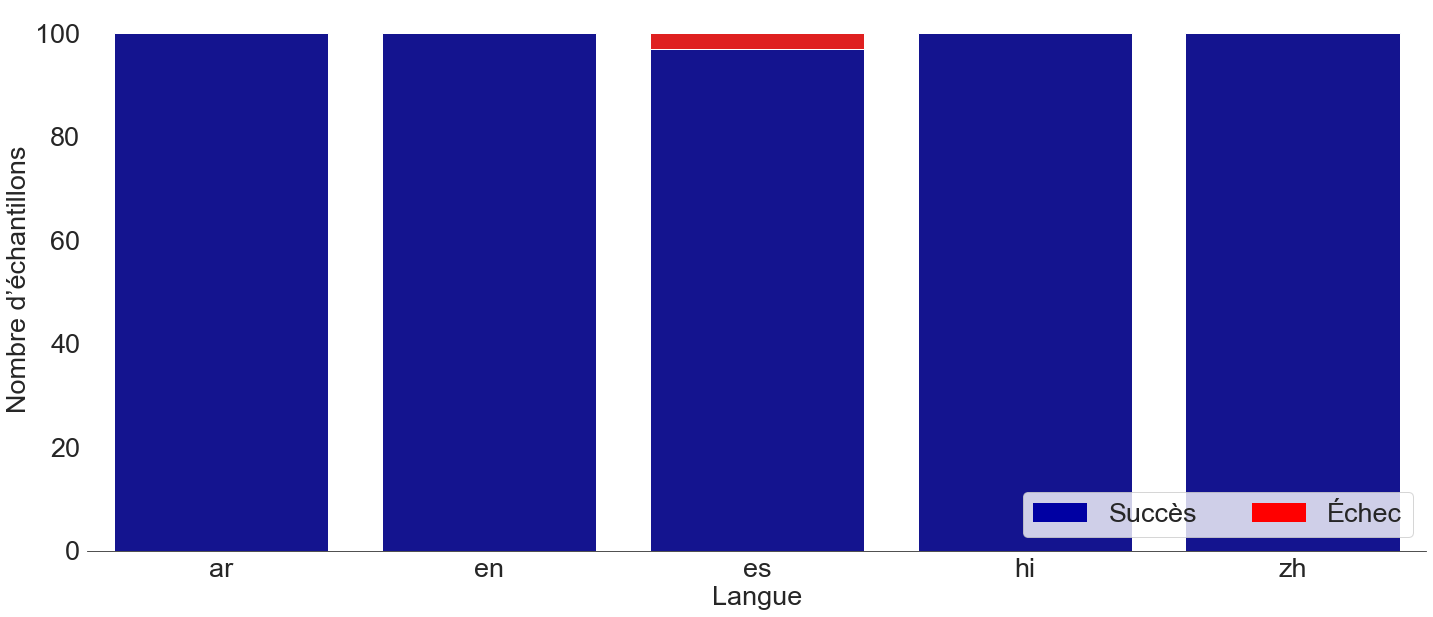

In [18]:
vizu()

# Conclusion